A notebook to complement report for AESM5120C showing all steps taken to apply data assimilation to a HBV model

In [1]:
from HBV_bmi import HBV
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import scipy
import random
import IPython
import tabulate
rng = np.random.default_rng() # Initiate a Random Number Generator

Load forcing data

In [2]:
df_in = pd.read_csv("Forcing.txt", delimiter="	", names=["year","month","day","P","Q","EP"])
df_in.index = df_in.apply(lambda x: pd.Timestamp(f'{int(x.year)}-{int(x.month)}-{int(x.day)}'),axis=1)
df_in.drop(columns=["year","month","day","P","EP"],inplace=True)
df = df_in # just need observations to compare to

In [3]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [4]:
# config settings to initialise BMI model
config_file = f"""{{
    "forcing_file": "Forcing.txt",
    "parameters": "{','.join([str(p) for p in par_0])}",
    "initial_storage":"{','.join([str(s) for s in s_0])}",
    "timestep": 1
}}
"""

with open("HBV_config.json", "w") as f:
    f.write(config_file)

Run one instance of the HBV model

In [5]:
model = HBV()
model.initialize(config_file="HBV_config.json")

In [6]:
Q_m = []
time = []
while model.get_current_time() < model.get_end_time():
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))

compare to previous implemented model to check

In [7]:
Q_m_in_ref = np.loadtxt("Q_m_out_ref.txt")

In [8]:
len(Q_m_in_ref)

1127

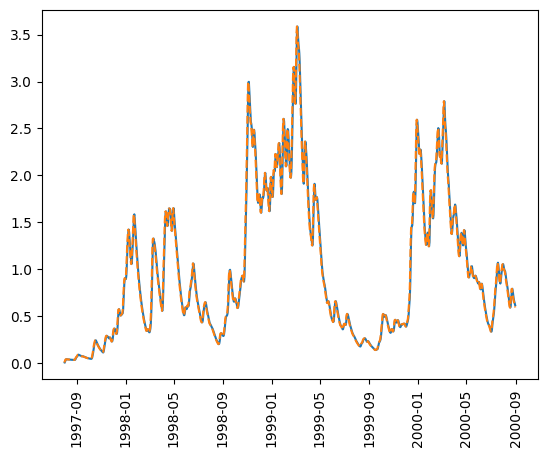

In [10]:
plt.plot(time, Q_m)
plt.plot(model.df_in.index, Q_m_in_ref,ls="--");
plt.xticks(rotation=90);
# identical

In [11]:
n_particles = 10

In [12]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [13]:
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

In [14]:
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []
    ensembleMember.storage_terms_lst = []

In [15]:
model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
time = []
while model.get_current_time() < model.get_end_time():
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))
        ensembleMember.storage_terms_lst.append(ensembleMember.get_value("storage_terms",np.zeros(4)))

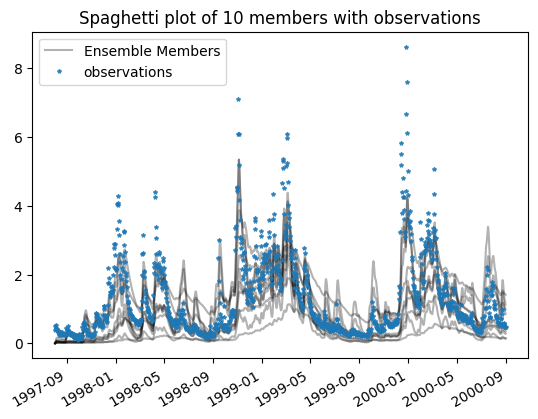

In [16]:
# plt.plot(time, Q_m,zorder=100,color="C3")
plt.title(f"Spaghetti plot of {n_particles} members with observations")
for index, ensembleMember in enumerate(ensemble[:-1]):
        plt.plot(time, ensembleMember.Q_m_list,color='k',alpha=0.3)
plt.plot(time, ensemble[-1].Q_m_list,color='k',alpha=0.3,label="Ensemble Members")
plt.xticks(rotation=90);
df.Q.plot(marker="*",lw=0, markersize=3, label="observations",alpha=0.8);
plt.legend();

Extract the storage terms (for adding reasonable noise later)

In [17]:
storage_terms = []
for ensembleMember in ensemble:
    storage_terms.append(np.array(ensembleMember.storage_terms_lst))
storage_terms = np.array(storage_terms)
storage_max = []

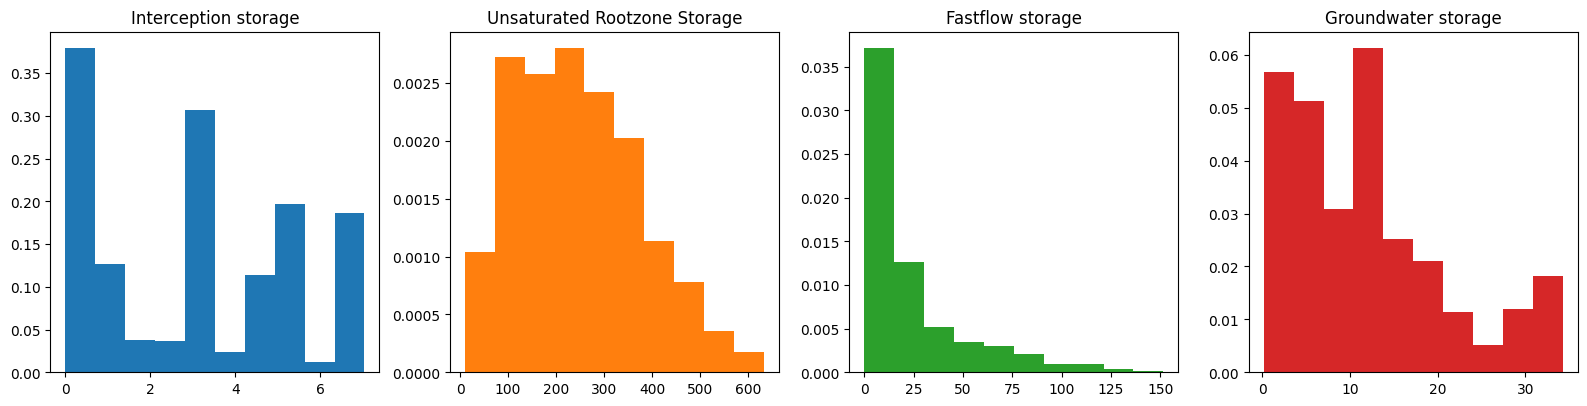

In [18]:
fig, ax = plt.subplots(1,4, figsize=(16,4))
fig.tight_layout(w_pad=2)
for index, storage_type in enumerate(storage_terms.T):
    ax[index].hist(storage_type.flatten(),density=True,color=f'C{index}')
    ax[index].set_title(S_names[index])
    storage_max.append(max(storage_type.flatten()))

# Just consider a few timesteps

In [19]:
n_particles = 500

In [20]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
np.random.seed(100) # for set up easy to keep this constant - know when changes affect plot
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# set up ensemble
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

# run initialisation & set the parameters
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []

model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
time = []
t_inital = 870393600
n_days = 60
d_2_sec = 24*3600
while model.get_current_time() < t_inital + n_days * d_2_sec:
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))

**Prior distribution of parameters can be represented**

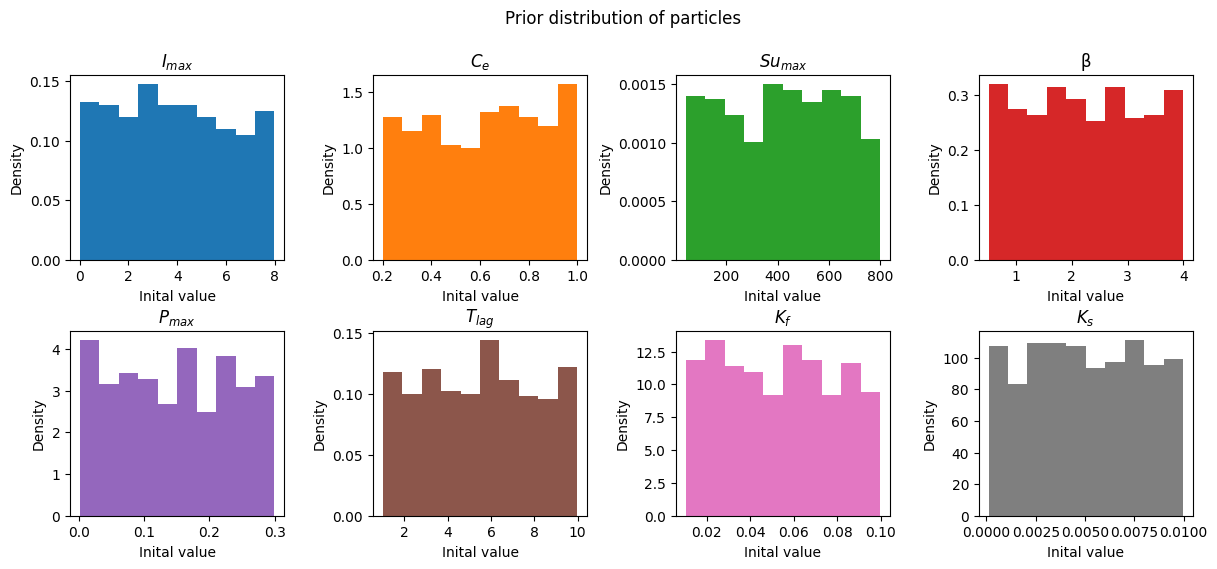

In [21]:
n_params = len(p_intial[0])
fig, ax = plt.subplots(2,n_params//2, figsize=(12,5))
fig.tight_layout(h_pad=3,w_pad=3)
fig.suptitle("Prior distribution of particles",y=1.09)
ax = ax.flatten()
for i in range(n_params):
    ax[i].hist(np.vstack(p_intial)[:,i],color=F"C{i}",density=True)
    # ax[i].bar(np.arange(1,n_particles+1,1),np.vstack(p_intial)[:,i], color=F"C{i}")
    # ax[i].set_xticks(np.arange(1,n_particles+1,1))
    ax[i].set_ylabel("Density")
    ax[i].set_xlabel("Inital value")
    ax[i].set_title(p_names[i])

In [22]:
prior_Q = np.array([ensembleMember.Q_m_list[-1] for ensembleMember in ensemble])

 the conceptual model needs about 30 day spin up time

Text(0, 0.5, 'Discharge in mm/d')

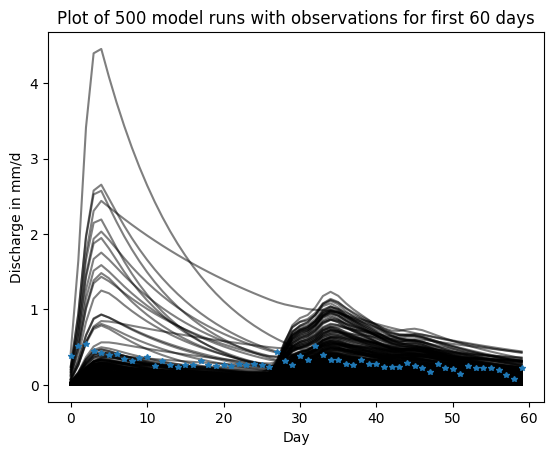

In [24]:
fig, ax = plt.subplots()
# ax.set_title(f"Spaghetti plot of {n_particles} members with observations for first 50 days")
title = f"Plot of {n_particles} model runs with observations for first 60 days"
ax.set_title(title)
ax.plot(df.iloc[:n_days].Q.values,marker="*",lw=0,zorder=10,ms=4)
[ax.plot(ensembleMember.Q_m_list,color="k",alpha=0.5) for ensembleMember in ensemble];

ax.set_xlabel("Day")
ax.set_ylabel("Discharge in mm/d")
# fig.savefig("Figures\\"+title+ ".png")

# repeat but for full time span & investigate errors & baseline comparison 

In [ ]:
n_particles = 500

In [ ]:
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])

In [ ]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
np.random.seed(100) # for set up easy to keep this constant - know when changes affect plot
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# set up ensemble
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

# run initialisation & set the parameters
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []

model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
time = []
while model.get_current_time() <= model.get_end_time(): # must be equal to to match length of Obs
    time.append(pd.Timestamp(model.get_current_time(), unit="s"))
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(time, df.Q.values,marker="*",lw=0,zorder=10,ms=4)
[ax.plot(time, ensembleMember.Q_m_list,color="k",alpha=0.5) for ensembleMember in ensemble];
ax.set_xlabel("Date")
ax.set_ylabel("Discharge in mm/d")
ax.set_title(f"Spaghetti plot of {n_particles} members with observations")
plt.xticks(rotation=90);

In [ ]:
Q_all = np.array([ensembleMember.Q_m_list for ensembleMember in ensemble])

In [ ]:
print(f'The mean of all ensemble values is {Q_all.mean():.3f} mm/d with a standard deviation of {Q_all.std():.3f} mm/d')
print(f'The mean of the observed values is {df.Q.mean():.3f} mm/d with a standard deviation of {df.Q.std():.3f} mm/d')

Look per ensemble member

In [ ]:
lst_std = [Qm.flatten().std() for Qm in Q_all]

Instead use [NSE](https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient)

In [ ]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [ ]:
lst_NSE = [calc_NSE(df.Q, Qm.flatten()) for Qm in Q_all]

plot both

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(lst_std,density=True)
plt.title("Histogram of standard deviation")
plt.ylabel("Density")
plt.xlabel("Standard deviation (mm/d)");

plt.subplot(122)
plt.hist(lst_NSE,density=True)
plt.title("Histogram of the Nash-Sutcliffe Efficiency")
plt.ylabel("Density")
plt.xlabel("NSE (-)");

In [ ]:
print(f'The maximum value of NSE is {max(lst_NSE):.2f}')

In [ ]:
best_model_run = ensemble[np.array(lst_NSE).argmax()]
par_opt = best_model_run.get_value("parameters",np.zeros(8))
print(tabulate.tabulate([par_opt],headers=param_names,tablefmt="simple"))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(time, df.Q.values,marker="*",lw=0,zorder=10,ms=4,label="observations")
[ax.plot(time, ensembleMember.Q_m_list,color="k",alpha=0.5) for ensembleMember in ensemble[:-1]];
ax.plot(time, ensemble[-1].Q_m_list,color="k",alpha=0.5, label="model run")
ax.plot(time, best_model_run.Q_m_list,color="C1",label="'best' model run")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Discharge in mm/d")
ax.set_title(f"Plot of {n_particles} model runs with observations")
plt.xticks(rotation=90);

Running and plotting 5000 model runs is time consuming, thus only done for 500 above


![figures\5000_runs_model.png](figures\5000_runs_model.png)

In [ ]:
fig, ax = plt.subplots()
t_n = 60
ax.plot(time[:t_n], df.Q.values[:t_n],marker="*",lw=0,zorder=10,ms=4,label="observations")
[ax.plot(time[:t_n], ensembleMember.Q_m_list[:t_n],color="k",alpha=0.5) for ensembleMember in ensemble[:-1]];
ax.plot(time[:t_n], ensemble[-1].Q_m_list[:t_n],color="k",alpha=0.5, label="model run")
ax.plot(time[:t_n], best_model_run.Q_m_list[:t_n],color="C1",label="'best' model run")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Discharge in mm/d")
tite = f"Plot of {n_particles} model runs with observations for first half a year"
ax.set_title(title)
fig.savefig("Figures\\"+title+ ".png")
plt.xticks(rotation=90);

# investigate likelyhood, posterior etc

In [ ]:
fig, ax = plt.subplots()
ax.hist(prior_Q, label='Prior')
ax.axvline(df.Q.iloc[n_days], c='k', lw=3, label='Observation')
ax.set_title('Prior ensemble of source strength')
ax.set_xlabel('Flow in mm/d')
ax.legend();

with thanks to [rlabbe](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb)

In [ ]:
innov2 = (df.Q.iloc[n_days] - prior_Q)**2
like_sigma = 0.005  # In [m]; so 5 mm

In [ ]:
unnormalised_log_weights = scipy.stats.norm.logpdf(innov2, loc=0, scale=like_sigma)
normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))

In [ ]:
fig, ax = plt.subplots()
ax.plot(prior_Q, normalised_weights, label='Post',marker=".",lw=0)
ax.axvline(df.Q.iloc[n_days], c='k', lw=1, label='Observation')
ax.set_title('Likelihood distribution of particles')
ax.set_xlabel('Flow in mm/d')
ax.set_ylabel('Likelihood')
ax.legend();

Clearly see a peak of likelihood around the observation, the spread of observations isn't great yet however 

**rewrite loop to include above code**  <br>

In [ ]:
def generate_weights(ensemble, obs):
    "Takes the enseble and observations and returns the posterior"
    prior = np.array([ensembleMember.Q_m_list[-1] for ensembleMember in ensemble]) # take last observation
    innov2 = (obs - prior)
    like_sigma = 0.05  # In [m]; so 5 mm
    unnormalised_log_weights = scipy.stats.norm.logpdf(innov2, loc=0, scale=like_sigma)
    normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))
    return normalised_weights

In [ ]:
n_particles = 500

In [ ]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
np.random.seed(100) # for set up easy to keep this constant - know when changes affect plot
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# set up ensemble
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV())

# run initialisation & set the parameters
for index, ensembleMember in enumerate(ensemble):
    ensembleMember.initialize(config_file="HBV_config.json")
    ensembleMember.set_pars(p_intial[index])
    ensembleMember.Q_m_list = []

model = HBV()
model.initialize(config_file="HBV_config.json")
Q_m = []
model_times = []
t_inital = 870393600
n_days = 50
d_2_sec = 24*3600
while model.get_current_time() < t_inital + n_days * d_2_sec:
    # do an inital model run 
    model.update()
    Q_m.append(model.get_value("Q_m", np.array([0.])))
    model_times.append(pd.Timestamp(model.get_current_time(), unit="s"))
    n = len(ensemble)

    # run each step for each member
    for index,ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))

    # post processeing
    Q_obs = df.loc[pd.Timestamp(model.get_current_time(), unit="s"),"Q"]
    likelihood = generate_weights(ensemble, Q_obs)

Investigate likelihoods for the last step, no real patterns however,m but could be in 8D space

In [ ]:
fig, ax = plt.subplots(3,3)
fig.tight_layout()
ax_index = ax.flatten()
set_title = True
for j, likelihood_j in enumerate(likelihood):
    for i in range(len(p_intial[0])):
        ax_index[i].plot(p_intial[j][i],likelihood_j, ".",markersize=5)
        if set_title: # only set it once
            ax_index[i].set_title(param_names[i])
            if i % 3 == 0:
                ax_index[i].set_ylabel("Likelyhood")
    set_title=False
ax_index[-1].axis('off'); # remove last one

In [ ]:
def generate_weights2(ensemble, obs):
    "Takes the enseble and observations and returns the posterior"
    prior = np.array([ensembleMember.Q_m_list[-1] for ensembleMember in ensemble]) # take last observation
    innov2 = (obs - prior)
    like_sigma = 0.05  # In [m]; so 5 mm
    unnormalised_log_weights = scipy.stats.norm.logpdf(innov2, loc=0, scale=like_sigma)
    normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))
    return normalised_weights

In [ ]:
def add_noise(like_sigma):
    return rng.normal(loc=0, scale=like_sigma)   # log normal so can't go to 0 ? 

In [ ]:
20%20

In [ ]:
def run_DA_model(n_particles):
    # for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
    # np.random.seed(101) # for set up easy to keep this constant - know when changes affect plot
    array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
    p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)
    
    # set up ensemble
    ensemble = []
    for i in range(n_particles):
        ensemble.append(HBV())
    
    # run initialisation & set the parameters
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.initialize(config_file="HBV_config.json")
        ensembleMember.set_pars(p_intial[index])
        ensembleMember.Q_m_list = []
    
    model = HBV()
    model.initialize(config_file="HBV_config.json")
    Q_m = []
    model_times = []
    store_all_parameters = []
    store_Q_obs = []
    store_Q_obs_times = []
    index_time = 0 
    resample_steps = 3
    # evaluate_posterior_step = 1
    while model.get_current_time() < model.get_end_time():
        # do an inital model run 
        model.update()
        Q_m.append(model.get_value("Q_m", np.array([0.])))
        model_times.append(pd.Timestamp(model.get_current_time(), unit="s"))
        n = len(ensemble)
    
        # run each step for each membere
        for index,ensembleMember in enumerate(ensemble):
            ensembleMember.update()
            ensembleMember.Q_m_list.append(ensembleMember.get_value("Q_m",np.array([0.])))
    
        ### only resample every number of resmpale steps: not per se every day
        if index_time % resample_steps == 0: 
            # processing of step
            Q_obs = df.loc[pd.Timestamp(model.get_current_time(), unit="s"),"Q"]
            likelihood = generate_weights2(ensemble, Q_obs)
            resample_indices = random.choices(population=np.arange(n),weights=likelihood, k=n)

            ### change to inherit states of the previous & add errors to parameters and states
            parameters_prior = np.array([ensembleMember.get_value("parameters",np.zeros(8))    for ensembleMember in ensemble])
            storage_prior    = np.array([ensembleMember.get_value("storage_terms",np.zeros(4)) for ensembleMember in ensemble])
            lag_terms_prior  = np.array([
                ensembleMember.get_value("memory_vector_lag",np.zeros(int(ensembleMember.get_value("Tlag",np.zeros(1))[0])))                                                                                                        for ensembleMember in ensemble])

            # resample
            new_parameters = parameters_prior[resample_indices]
            new_storage    = storage_prior[resample_indices]
            new_lag        = lag_terms_prior[resample_indices]

            # add noise
            sigma = 0.005
            new_parameters = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in par]) 
                                       for par in new_parameters.T]).T
            new_storage    = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in stor]) 
                                       for stor in new_storage.T]).T
            new_lag        = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in lag]) 
                                       for lag in new_lag.T]).T


            store_all_parameters.append(new_parameters)

            # update the parameters & states
            for index, ensembleMember in enumerate(ensemble):
                ensembleMember.set_pars(new_parameters[index])
                ensembleMember.set_storage(new_storage[index])
                ensembleMember.set_value("memory_vector_lag", new_lag[index])
            
            store_Q_obs.append(Q_obs)
            store_Q_obs_times.append(pd.Timestamp(model.get_current_time(), unit="s"))
        
        index_time += 1
    return ensemble, model_times, store_all_parameters,store_Q_obs,store_Q_obs_times

In [ ]:
n_particles = 50
ensemble, model_times, store_all_parameters, store_Q_obs, store_Q_obs_times = run_DA_model(n_particles)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title(f"Assimimilated flow data set with observations plotted over {n_particles} different particles")
ax.plot(store_Q_obs_times,store_Q_obs,marker="*",lw=0,zorder=4,ms=4,label="Observations")
[ax.plot(model_times,ensembleMember.Q_m_list,alpha=0.5) for ensembleMember in ensemble];
plt.xticks(rotation=90);
ax.legend()

In [ ]:
lst_Q = [ensembleMember.Q_m_list for ensembleMember in ensemble]
arr_Q = np.array(lst_Q)

In [ ]:
Q_all = np.array([ensembleMember.Q_m_list for ensembleMember in ensemble])
lst_NSE = np.array([calc_NSE(df.Q.iloc[:-1], Qm.flatten()) for Qm in Q_all])

In [ ]:
lst_NSE.min(),lst_NSE.max()

In [ ]:
plt.hist(lst_NSE,density=True,color="C1")
plt.axvline(lst_NSE.mean(),color="k")
plt.title("Histogram of the Nash-Sutcliffe Efficiency")
plt.ylabel("Density")
plt.xlabel("NSE (-)");

In [ ]:
fig, ax = plt.subplots()
t_n = 60
title = f"Assimimilated data for {n_particles} different particle runs for first {t_n} days"
ax.set_title(title)

ax.plot(model_times[:t_n],df.Q.iloc[:t_n].values,marker="*",lw=0,zorder=10,ms=4)
[ax.plot(model_times[:t_n],ensembleMember.Q_m_list[:t_n],alpha=0.5) for ensembleMember in ensemble];
plt.xticks(rotation=90);
fig.savefig("Figures\\"+title+ ".png")
# plt.xlim((pd.Timestamp("10-1998"),pd.Timestamp("2000")))

### look into uncertainty

In [ ]:
lst_std = []
lst_mean = []
for i in range(len(arr_Q[0])):
    lst_std.append(arr_Q[:,i].std())
    lst_mean.append(arr_Q[:,i].mean())

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(model_times,df.Q.iloc[:-1].values,marker="*",lw=0,zorder=4,ms=4,label="Observations")
ax.plot(model_times, lst_mean,label="Mean")
[ax.plot(model_times,ensembleMember.Q_m_list,alpha=0.1,zorder=-5,color='k') for ensembleMember in ensemble[:-1]];
ax.plot(model_times,ensemble[-1].Q_m_list,alpha=0.1,zorder=-5,color='k',label="ensemble")
ax.set_title("Mean of observations per timestep with observations")
ax.set_ylabel("$\mu$ Q mm/d")
plt.xticks(rotation=90);
ax.legend()

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Standard deviation of observations per timestep")
ax.plot(df.iloc[:-1].index, lst_std,lw=0.1,marker=".")
ax.axhline(np.mean(lst_std),color="k")
ax.annotate(f'μ={np.mean(lst_std):.2f}',(pd.Timestamp('1997-06-10 00:00:00'),np.mean(lst_std)+0.002))
ax.set_ylabel("$\sigma$Q mm/d")
plt.xticks(rotation=90);

In [ ]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].set_title("Standard deviation of observations per timestep")
ax[0].plot(df.iloc[:-1].index, lst_std,lw=0.1,marker=".")
ax[1].set_title("Mean of observations per timestep")
ax[1].plot(df.iloc[:-1].index, lst_mean,color="C1")

ax[0].set_ylabel("$\sigma$Q mm/d")
ax[1].set_ylabel("$\mu$ Q mm/d")
plt.xticks(rotation=90);

### Investigate changes in parameters over time

Compare with best model run from brute force

In [ ]:
table = '   Imax        Ce    Sumax     beta      Pmax    Tlag         Kf          Ks\n-------  --------  -------  -------  --------  ------  ---------  ----------\n6.81298  0.69513  266.524  1.72191  0.135332       2  0.0979114  0.00566184'
print(table)
optimal_parameters_bulk = [6.81298,0.69513,266.524,1.72191,0.135332,2,0.0979114,0.00566184]

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(12,5))
fig.tight_layout(h_pad=3)
ax_index = ax.flatten()
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
array_per_param = np.array(store_all_parameters).T
for j, params in enumerate(array_per_param):
    set_title = True
    for i in range(len(params)):
        ax_index[j].plot(params[i], ".",markersize=0.1)
        if set_title: # only set it once
            ax_index[j].set_title(param_names[j])
            ax_index[j].axhline(p_min_initial[j],color="k")
            ax_index[j].axhline(p_max_initial[j],color='k')
            ax_index[j].set_ylabel("Value")
            ax_index[j].set_xlabel("Day number")
            ax_index[j].axhline(optimal_parameters_bulk[j],color="C1")


    set_title=False
# ax_index[-1].axis('off'); # remove last one
ax_index[-1].axhline(optimal_parameters_bulk[-1],color="C1",label="Comparison optimal \nparameter set")
ax_index[-1].legend(bbox_to_anchor=(1,1));

only consider trend

repeat for many particles

In [ ]:
run = False # takes a long time - last run start 14:36, end 14:44, 21:15, end at  
n_particles = 50
n_runs = 50
if run:
    store_NSEs = []
    store_ensembles = []
    for i in range(n_runs):
        ensemble, model_times, store_all_parameters = run_DA_model(n_particles)
        Q_all = np.array([ensembleMember.Q_m_list for ensembleMember in ensemble])
        lst_NSE = np.array([calc_NSE(df.Q.iloc[:-1], Qm.flatten()) for Qm in Q_all])
        store_NSEs.append(lst_NSE.mean())
        store_ensembles.append(ensemble)

In [ ]:
fname = f"figures\mean_NSE_{n_particles}_particels_{n_runs}_runs.png"
if run:
    plt.hist(store_NSEs,density=True)
    plt.title(f"Histogram of the mean Nash-Sutcliffe Efficiency of \n {n_runs} different runs with {n_particles} particeles")
    plt.ylabel("Density")
    plt.xlabel("NSE (-)");
    plt.savefig(fname)
    plt.close()

IPython.display.Image(fname)

This shows there is still some variablility when using 50 particels

In [ ]:
fname = f"figures\\best_vs_worst_runs_for_{n_particles}_particels_{n_runs}_runs.png"
if run:
    best_ensemble = store_ensembles[np.array(store_NSEs).argmax()]
    worst_ensemble = store_ensembles[np.array(store_NSEs).argmin()]

    fig, ax = plt.subplots(2,1,figsize=(12,8))
    ax[0].set_title(f"Worst outcome of {n_particles} different particle runs from {n_runs}")
    ax[0].plot(model_times,df.Q.iloc[:-1].values,marker="*",lw=0,zorder=10,ms=4)
    [ax[0].plot(model_times,ensembleMember.Q_m_list,alpha=0.5) for ensembleMember in worst_ensemble];
    
    
    ax[1].set_title(f"Best outcome of {n_particles} different particle runs from {n_runs}")
    ax[1].plot(model_times,df.Q.iloc[:-1].values,marker="*",lw=0,zorder=10,ms=4)
    [ax[1].plot(model_times,ensembleMember.Q_m_list,alpha=0.5) for ensembleMember in best_ensemble];

    fig.savefig(fname)
    plt.close(fig)
IPython.display.Image(fname)

In [ ]:
n_particles = 500
ensemble, model_times, store_all_parameters, store_Q_obs, store_Q_obs_times = run_DA_model(n_particles)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title(f"Assimimilated flow data set with observations plotted over {n_particles} different particle runs")
ax.plot(store_Q_obs_times, store_Q_obs,marker="*",lw=0,zorder=10,ms=4)
[ax.plot(model_times,ensembleMember.Q_m_list,alpha=0.5) for ensembleMember in ensemble];
plt.xticks(rotation=90);
# plt.xlim((pd.Timestamp("10-1998"),pd.Timestamp("2000")))

In [ ]:
Q_all = np.array([ensembleMember.Q_m_list for ensembleMember in ensemble])
lst_NSE = np.array([calc_NSE(df.Q.iloc[:-1], Qm.flatten()) for Qm in Q_all])

In [ ]:
plt.hist(lst_NSE,density=True)
plt.title("Histogram of the Nash-Sutcliffe Efficiency")
plt.ylabel("Density")
plt.xlabel("NSE (-)");

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(6,5))
fig.tight_layout(h_pad=3)
ax_index = ax.flatten()
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
array_per_param = np.array(store_all_parameters).T
for j, params in enumerate(array_per_param):
    set_title = True
    for i in range(len(params)):
        ax_index[j].plot(params[i], ".",markersize=0.1)
        if set_title: # only set it once
            ax_index[j].set_title(param_names[j])
            ax_index[j].axhline(p_min_initial[j],color="k")
            ax_index[j].axhline(p_max_initial[j],color='k')
            ax_index[j].set_ylabel("Value")
            ax_index[j].set_xlabel("Day number")
    set_title=False
ax_index[-1].axis('off'); # remove last one